# Autoencoder + KMeans / DEC for Daily-Shape Clustering
This notebook pretrains an autoencoder to learn embeddings, runs KMeans, then performs DEC fine-tuning.
Outputs: cluster labels, metrics, and a t-SNE plot.

In [1]:
import os, json, math, numpy as np, torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset
from nb_utils import load_eld_daily, evaluate_clustering, plot_tsne, save_outputs, seed_everything
seed_everything(42)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
DATA_PATH = '../data/LD2011_2014.txt'
OUT_DIR = '../results_ae'
SAMPLE_SIZE = 3000
BATCH_SIZE = 256
EPOCHS_PRE = 80
EPOCHS_DEC = 80
N_CLUSTERS = 5
LR = 1e-3
X, meta = load_eld_daily(DATA_PATH, normalize='zscore', sample_size=SAMPLE_SIZE)
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
X.shape

(3000, 24)

In [3]:

class AE(nn.Module):
    def __init__(self, in_dim=24, emb_dim=10):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, emb_dim)
        )
        self.dec = nn.Sequential(
            nn.Linear(emb_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, in_dim)
        )
    def encode(self, x): return self.enc(x)
    def forward(self, x): return self.dec(self.enc(x))

ae = AE().to(DEVICE)
opt = optim.Adam(ae.parameters(), lr=LR)
mse = nn.MSELoss()
    

### Pretrain AE (reconstruction)

In [4]:

for epoch in range(1, EPOCHS_PRE+1):
    loss_acc = 0.
    for (xb,) in loader:
        xb = xb.to(DEVICE)
        opt.zero_grad()
        rec = ae(xb)
        loss = mse(rec, xb)
        loss.backward()
        opt.step()
        loss_acc += loss.item()
    if epoch % 20 == 0 or epoch == 1:
        print(f"AE pretrain epoch {epoch}/{EPOCHS_PRE}  loss {loss_acc/len(loader):.6f}")
    

AE pretrain epoch 1/80  loss 0.865954
AE pretrain epoch 20/80  loss 0.050562
AE pretrain epoch 40/80  loss 0.031202
AE pretrain epoch 60/80  loss 0.020858
AE pretrain epoch 80/80  loss 0.017529


### Get embeddings & run KMeans

In [5]:
with torch.no_grad():
    Z = ae.encode(torch.tensor(X, dtype=torch.float32, device=DEVICE)).cpu().numpy()
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=20, random_state=42)
labels_km = kmeans.fit_predict(Z)
metrics_km = evaluate_clustering(X, labels_km)
print('KMeans on AE embeddings:', metrics_km)

KMeans on AE embeddings: {'silhouette': 0.1763148158788681, 'davies_bouldin': 2.0254035487587605}


### DEC fine-tuning
We use the student-t distribution and KL divergence as in the DEC paper.

In [7]:

# Initialize cluster centers with KMeans
centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device=DEVICE, requires_grad=True)
opt_dec = optim.Adam(list(ae.parameters()) + [centers], lr=1e-3)

def target_distribution(q):
    weight = (q ** 2) / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

def soft_assign(z, centers, alpha=1.0):
    # Student-t distribution q_ij
    P = 1.0 / (1.0 + ((z.unsqueeze(1) - centers.unsqueeze(0))**2).sum(2) / alpha)
    P = P ** ((alpha + 1.0)/2.0)
    q = (P.t() / P.sum(1)).t()
    return q

# Prepare full-batch tensors for simplicity
X_t = torch.tensor(X, dtype=torch.float32, device=DEVICE)

for epoch in range(1, EPOCHS_DEC+1):
    opt_dec.zero_grad()
    z = ae.encode(X_t)
    q = soft_assign(z, centers)
    p = target_distribution(q).detach()
    loss_kl = torch.nn.functional.kl_div((q+1e-10).log(), p, reduction='batchmean')
    # Add small reconstruction tie-in to keep structure
    rec = ae.dec(z)
    loss_rec = mse(rec, X_t)
    (loss_kl + 0.1*loss_rec).backward()
    opt_dec.step()
    if epoch % 20 == 0 or epoch == 1:
        print(f"DEC epoch {epoch}/{EPOCHS_DEC}  KL {loss_kl.item():.4f}  Rec {loss_rec.item():.5f}")
    

DEC epoch 1/80  KL 0.0740  Rec 0.01726
DEC epoch 20/80  KL 0.0909  Rec 0.02367
DEC epoch 40/80  KL 0.0998  Rec 0.03259
DEC epoch 60/80  KL 0.1077  Rec 0.04332
DEC epoch 40/80  KL 0.0998  Rec 0.03259
DEC epoch 60/80  KL 0.1077  Rec 0.04332
DEC epoch 80/80  KL 0.1209  Rec 0.05218
DEC epoch 80/80  KL 0.1209  Rec 0.05218


### Final labels, metrics, plots

DEC metrics: {'silhouette': 0.16109798848628998, 'davies_bouldin': 2.1736449511028555}


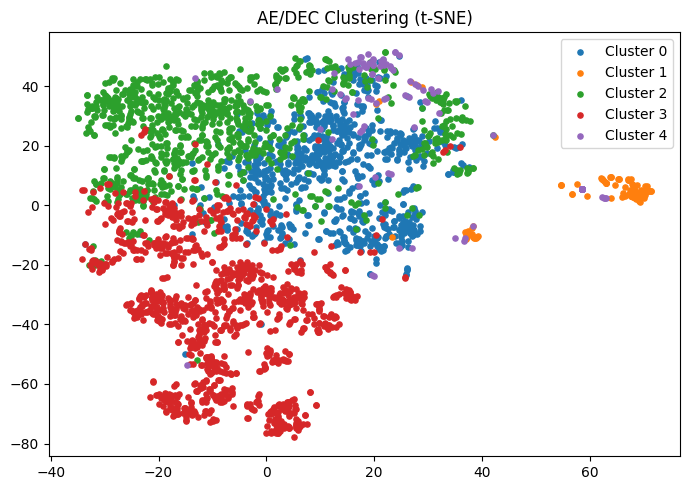

Saved to ../results_ae


In [8]:
with torch.no_grad():
    Z = ae.encode(torch.tensor(X, dtype=torch.float32, device=DEVICE)).cpu().numpy()
    centers_np = centers.detach().cpu().numpy()
from sklearn.metrics.pairwise import euclidean_distances
d = euclidean_distances(Z, centers_np)
labels = d.argmin(axis=1)
metrics = evaluate_clustering(X, labels)
print('DEC metrics:', metrics)
plot_tsne(X, labels, title='AE/DEC Clustering (t-SNE)', savepath=os.path.join(OUT_DIR, 'tsne_ae_dec.png'))
save_outputs(OUT_DIR, 'ae_dec', labels, Z, metrics)
print('Saved to', OUT_DIR)

## Task: Quick EDA — inspect a few daily profiles

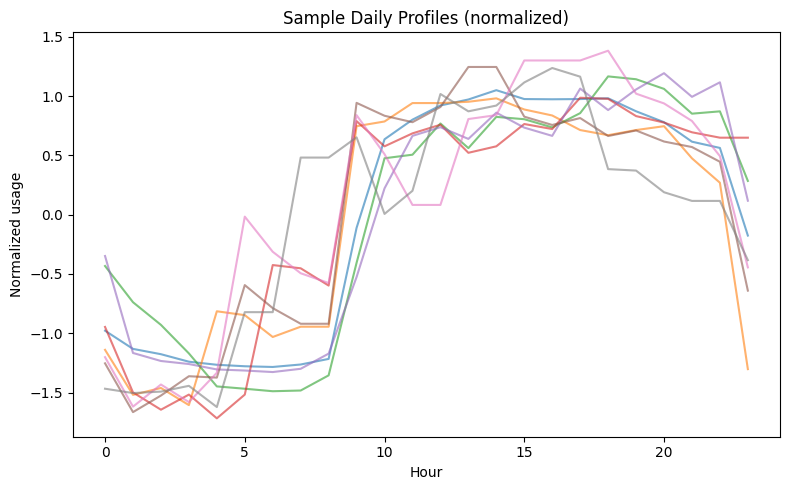

In [9]:
import numpy as np, matplotlib.pyplot as plt
idx = np.random.choice(len(X), size=min(8, len(X)), replace=False)
hours = np.arange(24)
plt.figure(figsize=(8,5))
for i in idx:
    plt.plot(hours, X[i], alpha=0.6)
plt.title('Sample Daily Profiles (normalized)')
plt.xlabel('Hour'); plt.ylabel('Normalized usage'); plt.tight_layout(); plt.show()

## Task: Cluster diagnostics — sizes, silhouettes, and mean profiles

Cluster sizes: [ 770  101  908 1117  104]


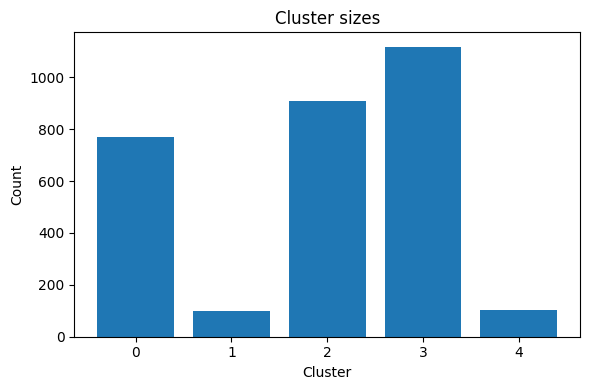

silhouette             
              mean median count
cluster                        
0            0.051  0.053   770
1            0.122  0.298   101
2            0.128  0.124   908
3            0.295  0.353  1117
4           -0.137 -0.185   104

In [10]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
labels = np.asarray(labels)
K = len(np.unique(labels))
sizes = np.bincount(labels, minlength=K)
print('Cluster sizes:', sizes)

# Bar chart of cluster sizes
plt.figure(figsize=(6,4))
plt.bar(np.arange(K), sizes)
plt.xlabel('Cluster'); plt.ylabel('Count'); plt.title('Cluster sizes')
plt.tight_layout(); plt.show()

# Per-sample silhouettes, then per-cluster summary
sil_samples = silhouette_samples(X, labels)
df = pd.DataFrame({'cluster': labels, 'silhouette': sil_samples})
summary = df.groupby('cluster').agg(['mean','median','count']).round(3)
summary

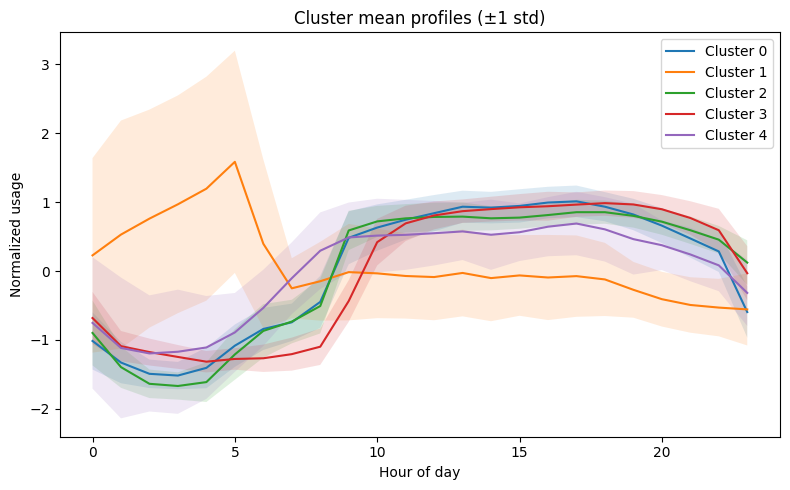

In [11]:
# Mean ± std 24h profile per cluster
hours = np.arange(24)
plt.figure(figsize=(8,5))
for k in range(K):
    Xk = X[labels==k]
    m = Xk.mean(axis=0)
    s = Xk.std(axis=0)
    plt.plot(hours, m, label=f'Cluster {k}')
    plt.fill_between(hours, m-s, m+s, alpha=0.15)
plt.xlabel('Hour of day'); plt.ylabel('Normalized usage')
plt.title('Cluster mean profiles (±1 std)')
plt.legend(); plt.tight_layout(); plt.show()

In [12]:
# Save a compact CSV summary (for report)
import os, json
summary_csv = summary.reset_index()
out_dir = OUT_DIR if 'OUT_DIR' in globals() else '.'
os.makedirs(out_dir, exist_ok=True)
summary_csv.to_csv(os.path.join(out_dir, 'cluster_summary.csv'), index=False)
print('Saved:', os.path.join(out_dir, 'cluster_summary.csv'))

Saved: ../results_ae\cluster_summary.csv
